In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout,Input
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import matplotlib.image as img
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D , GlobalAvgPool2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from pathlib import Path
import numpy as np
import cv2
from keras.preprocessing.image import load_img
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import os
from PIL import Image
import time
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
labels = ['Blight', 'Common_Rust','Gray_Leaf_Spot','Healthy']
#defining the image size to 148 as per instructions.
img_size = 256
#defining a function called getdata to get the data and resize it to the image size of 148*148
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_ar = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_ar, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
              print(e)
    return np.array(data)


In [3]:
#calling the function getdata on our images folder present in the directory of google drive.
df = get_data('maize\Data')
#Assigning them to a dataframe with columns images and labels 
data=pd.DataFrame(df, columns=['images','labels'])
data = data.sample(frac=1).reset_index(drop=True)


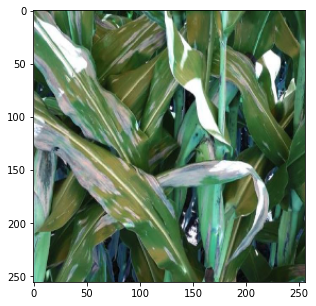

In [4]:
#Displaying a sample image of the object(car)
plt.figure(figsize = (5,5))
plt.imshow(df[2][0])

In [5]:
x1=np.array(list(data.images))
y1=np.array(list(data.labels))
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

x_train, x_test, y_train, y_test = train_test_split(x1, y1,stratify=y1,test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,stratify=y_train,test_size=0.2, random_state=10)
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255
Y_train = to_categorical(y_train)
Y_test =  to_categorical(y_test)
Y_val =  to_categorical(y_val)

In [6]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(2680, 256, 256, 3)
(670, 256, 256, 3)
(838, 256, 256, 3)
(2680,)
(670,)
(838,)


In [42]:
data_generator = ImageDataGenerator(rotation_range = 30,
                                         width_shift_range = 0.2, 
                                         height_shift_range = 0.2,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True,
                                         vertical_flip = True)

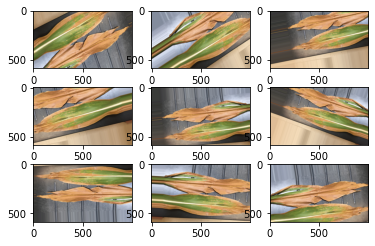

In [8]:
image=load_img('maize/data/Blight/Corn_Blight (1).jpeg')
data = img_to_array(image)
from numpy import expand_dims
samples = expand_dims(data, 0)
it = data_generator.flow(samples, batch_size=1)
import matplotlib.pyplot as plt
for i in range(9):
        plt.subplot(330 + 1 + i)
        batch = it.next()
        image = batch[0].astype('uint8')
        plt.imshow(image)
plt.show()

In [44]:
train_ds = data_generator.flow(x_train, Y_train,batch_size = 16)
val_ds = data_generator.flow(x_val, Y_val,batch_size = 16)
test_ds = data_generator.flow(x_test, Y_test,batch_size = 16)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(4, activation="softmax"))
model.summary()

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

In [ ]:
history=model.fit(train_ds, 
                    epochs=10,
                    validation_data=val_ds)

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print('test_acc:', test_ds)

In [ ]:
model.save("maize.h5")

In [10]:
from keras.applications.vgg16 import VGG16
input_layer = Input(shape = (256, 256, 3))

vgg_model = VGG16(include_top=False,weights="imagenet", input_shape = (256, 256, 3))

vgg16_model = Sequential()
vgg16_model.add(vgg_model)

vgg16_model.add(Flatten())
vgg16_model.add(Dense(256,activation='relu'))
vgg16_model.add(Dropout(0.25))
vgg16_model.add(Dense(4,activation='softmax'))

adam = Adam(lr= 0.0001, decay=0.0001 / 10)

C:\Users\bhuva\anaconda3\envs\DAB30021F\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
vgg16_model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [12]:
history = vgg16_model.fit(train_ds, 
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
42/42 [==============================] - ETA: 0s - loss: 0.7860 - accuracy: 0.6694 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000014EAA7B69D8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

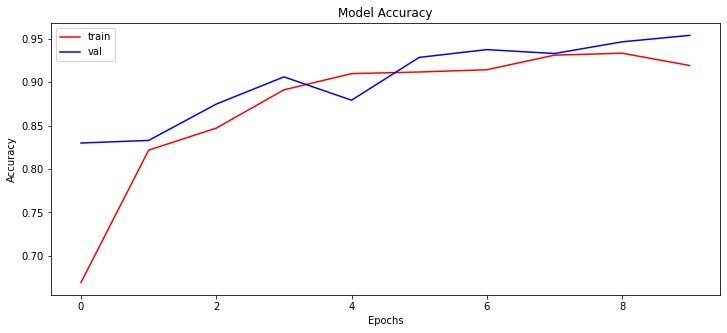

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [15]:
test_loss, test_acc = vgg16_model.evaluate(test_ds)
print('test_acc:', test_ds)

14/14 [==============================] - 324s 23s/step - loss: 0.1646 - accuracy: 0.9379
test_acc: <keras.preprocessing.image.NumpyArrayIterator object at 0x0000014EAA0D1C48>


In [13]:
vgg16_model.save("maize1.h5")

In [69]:
import keras
model2 = keras.models.Sequential([
        keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (256, 256, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.5),
        keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Dropout(0.5),
        keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(32, activation ='relu'),
        keras.layers.Dense(4, activation='softmax')
    ])

In [70]:
import tensorflow as tf
model2.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics  = ['accuracy']
    )

In [71]:
history = model2.fit(train_ds, 
                    epochs=50,
                    validation_data=val_ds)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
168/168 [==============================] - ETA: 0s - loss: 1.0175 - accuracy: 0.5340WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000014E86121C18> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

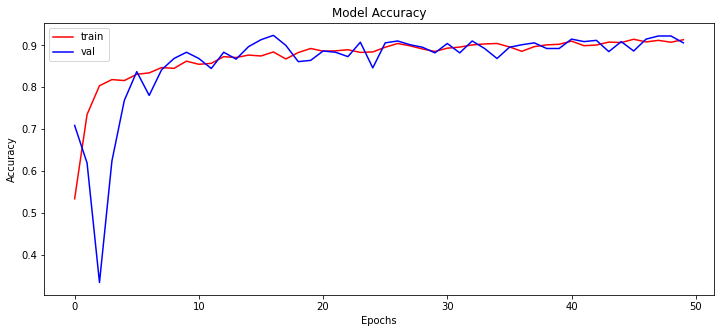

In [72]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [73]:
test_loss, test_acc = model2.evaluate(test_ds)
print('test_acc:', test_ds)

53/53 [==============================] - 23s 433ms/step - loss: 0.2428 - accuracy: 0.9117
test_acc: <keras.preprocessing.image.NumpyArrayIterator object at 0x0000014EA9CFDBC8>


In [74]:
model2.save("maize2.h5")

# CHECK

In [75]:
CLASS_NAMES = ['blight', 'common rust', 'gray','healthy']

In [85]:
import numpy as np
from keras.preprocessing import image

img_width, img_height = 256, 256
img = image.load_img('b1.jpg', target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

output=model2.predict(img)
np.set_printoptions(suppress=True)
output

array([[0.27580583, 0.7241942 , 0.        , 0.        ]], dtype=float32)

In [77]:
np.set_printoptions(suppress=True)
output

array([[0., 0., 0., 1.]], dtype=float32)

In [86]:
Y_pred =vgg16_model.predict(img)
result = CLASS_NAMES[np.argmax(Y_pred)]
result

'blight'